In [1]:
import sys
sys.path.append("../")
from utils.datasets import Datasets
from utils.save_results import save_info, plot_graph, plot_scatter
from utils.utils import dict_to_PCA

from utils.classifier_centerloss import ClassifierCenterLoss
from utils.centerloss import CenterLoss
from utils.networks import Net

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

f:\university\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

#Dataset config
DATASET = 'MNIST'
DATASET_DIR = './dataset'
BATCH_SIZE = 100
NUM_WORKERS = 2

#Optimizer config
WEIGHT_DECAY = 0.001
LEARNING_RATE = 0.01
GAMMA = 0.1
STEPS = 50

#Training config
EPOCH = 100

#Center Loss config
DIM = 2
ALPHA = 1.0
LAMBDA = 0.5

In [3]:
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_trans = transforms.Compose(
    [
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
test_trans = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.485, 0.456, 0.406),
        #                     (0.229, 0.224, 0.225)),
    ],
)
instance_datasets = Datasets(
    DATASET,
    BATCH_SIZE,
    NUM_WORKERS,
    transform=train_trans,
    test_transform=test_trans,
    dataset_dir=DATASET_DIR,
)
data_sets = instance_datasets.create()

trainloader = data_sets[0]
testloader = data_sets[1]
classes = data_sets[2]
based_labels = data_sets[3]
input_channels = data_sets[4]
trainset = data_sets[5]
testset = data_sets[6]

Dataset : MNIST
set train data
set test data


In [5]:
model = Net(
    input_channels=input_channels,
    num_classes=len(classes),
    dim=DIM,
).to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=STEPS,
    gamma=GAMMA,
)

criterion = nn.CrossEntropyLoss()
centerloss = CenterLoss(
    len(classes),
    DIM,
    ALPHA,
)

cfcl = ClassifierCenterLoss(
    model,
    optimizer,
    criterion,
    centerloss,
    LAMBDA,
)

In [6]:
losses, cel_losses, center_losses, accuracies = cfcl.fit(
    EPOCH,
    trainloader,
    testloader,
    scheduler=scheduler,
    device=device,
)

epoch:1


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 27.14it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 61.43it/s]


mean_loss=1.2257662298281988, mean_cel_loss=1.1532020286719005, mean_center_loss=0.14512840172896782, acc=0.6399
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.83it/s]


mean_loss=1.222948340177536, mean_cel_loss=1.1516348612308502, mean_center_loss=0.1426269616931677, acc=0.6436
epoch:2


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:22<00:00, 26.99it/s]


Training data results-----------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 61.72it/s]


mean_loss=0.9184171751141548, mean_cel_loss=0.8574829750259717, mean_center_loss=0.12186839878559112, acc=0.7214166666666667
Test data results---------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.50it/s]

mean_loss=0.9208003932237625, mean_cel_loss=0.857912524342537, mean_center_loss=0.12577574498951435, acc=0.7176


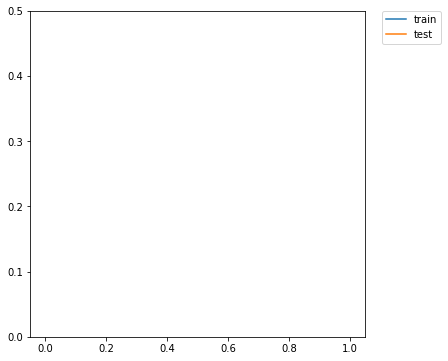

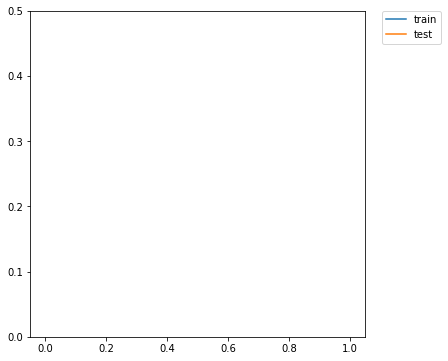

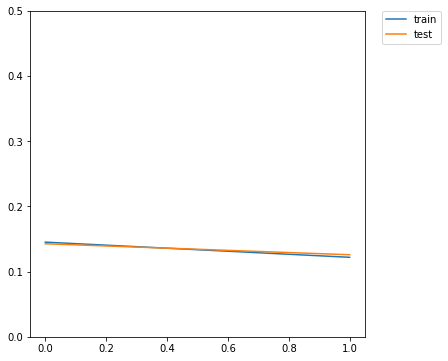

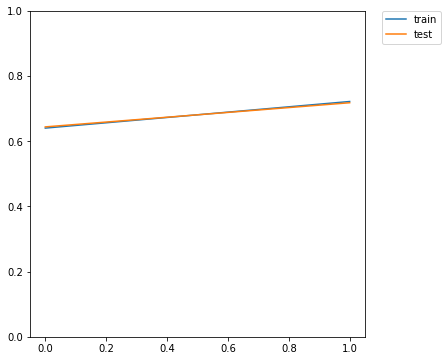

In [7]:
plot_graph(losses, 0.5, filename="loss")
plot_graph(cel_losses, 0.5, filename="cross entropy loss")
plot_graph(center_losses, 0.5, filename="center loss")
plot_graph(accuracies, 1, filename="accuracy")

In [8]:
info = {}
info["DATASET"] = DATASET
info["Learnign_rate"] = LEARNING_RATE
info["Weight_decay"] = WEIGHT_DECAY
info["EPOCH"] = EPOCH
info["STEPS"] = STEPS
info["GAMMA"] = GAMMA
info["Model"] = model
info["Criterion"] = criterion
info["Optimizer"] = optimizer
info["train_loss"] = losses["train"][-1]
info["test_loss"] = losses["test"][-1]
info["train_cel_loss"] = cel_losses["train"][-1]
info["test_cel_loss"] = cel_losses["test"][-1]
info["train_center_loss"] = center_losses["train"][-1]
info["test_center_loss"] = center_losses["test"][-1]
info["train_acc"] = accuracies["train"][-1]
info["test_acc"] = accuracies["test"][-1]
info["DIM"] = DIM
info["ALPHA"] = ALPHA
info["LAMBDA"] = LAMBDA

In [9]:
save_info(info, DATASET+"_info")

In [10]:
torch.save(model.cpu().state_dict(), 'model_param.pth')
torch.save(model.cpu(), 'model.pth')

In [12]:
train_embedding = cfcl.getLatents(trainloader, based_labels, device)
test_embedding = cfcl.getLatents(testloader, based_labels, device)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.03it/s]


In [13]:
train_embedding, test_embedding, pca = dict_to_PCA(
    train_embedding,
    test_embedding,
    dim=2,
)

11it [00:00, ?it/s]
11it [00:00, ?it/s]


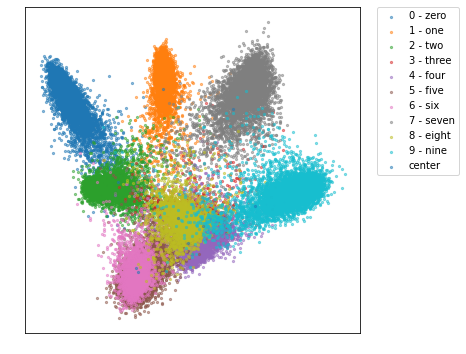

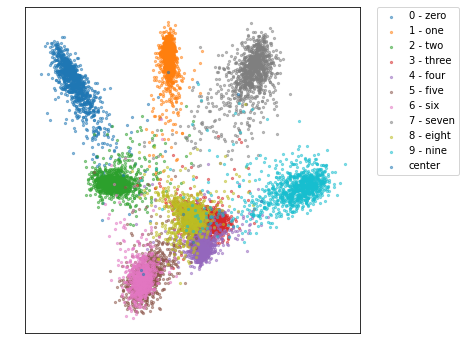

In [14]:
plot_scatter(train_embedding, filename="train_embeddings")
plot_scatter(test_embedding, filename="test_embeddings")